# Contract Amendments Extractor


 
 This notebook demonstrates how to extract changes between original and amended contract documents using a language model. It includes steps for loading data, defining the extraction schema, building the processing graph, and evaluating the extraction quality.

## Setup and Imports

In [1]:
import os
import json
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
import base64
from dotenv import load_dotenv
from IPython.display import Image, display

In [2]:
import numpy as np

In [3]:
from langchain_anthropic import ChatAnthropic
from langchain.messages import HumanMessage
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, Send

In [4]:
from typing_extensions import TypedDict
from typing import Literal
from pydantic import BaseModel, Field


In [5]:
from langfuse.langchain import CallbackHandler

In [6]:
def print_highlighted_json(json_dict: dict):
    """Prints a JSON string with syntax highlighting for terminal output."""
    formatter = TerminalFormatter()
    highlighted_json = highlight(json.dumps(json_dict, indent=4), JsonLexer(), formatter)
    print(highlighted_json)

### Load Environment Variables

In [7]:
root_dir = os.path.abspath(".")
env_file = os.path.abspath(os.path.join(root_dir, ".env"))

In [8]:
VISION_MODEL = "claude-haiku-4-5-20251001"
EMBEDDING_MODEL = "text-embedding-3-small"
COMPLETION_MODEL = "gpt-4.1-mini"

In [9]:
# Try to load environment variables from env_file (if present). If loading fails, fall back to defaults.
if os.path.exists(env_file):
    load_dotenv(env_file)
    EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL", EMBEDDING_MODEL)
    COMPLETION_MODEL = os.getenv("COMPLETION_MODEL", COMPLETION_MODEL)
    LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
    LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY")
    LANGFUSE_BASE_URL = os.getenv("LANGFUSE_BASE_URL")   

## Dataset

In [10]:
data_path = "data/test_contracts"
dataset = [
    {
        "original_path": data_path + f"/{str(i).zfill(2) }/" + str(i).zfill(2) + "_original_scan.pdf",
        "amendment_path": data_path + f"/{str(i).zfill(2) }/" + str(i).zfill(2) + "_amendment_scan.pdf",
        "original_md_path": data_path + f"/{str(i).zfill(2) }/" + str(i).zfill(2) + "_original.md",
        "amendment_md_path": data_path + f"/{str(i).zfill(2) }/" + str(i).zfill(2) + "_amendment.md",
        "changes_readme": data_path + f"/{str(i).zfill(2) }/" + "README.md",
    }
    for i in range(1,4)
]
dataset

[{'original_path': 'data/test_contracts/01/01_original_scan.pdf',
  'amendment_path': 'data/test_contracts/01/01_amendment_scan.pdf',
  'original_md_path': 'data/test_contracts/01/01_original.md',
  'amendment_md_path': 'data/test_contracts/01/01_amendment.md',
  'changes_readme': 'data/test_contracts/01/README.md'},
 {'original_path': 'data/test_contracts/02/02_original_scan.pdf',
  'amendment_path': 'data/test_contracts/02/02_amendment_scan.pdf',
  'original_md_path': 'data/test_contracts/02/02_original.md',
  'amendment_md_path': 'data/test_contracts/02/02_amendment.md',
  'changes_readme': 'data/test_contracts/02/README.md'},
 {'original_path': 'data/test_contracts/03/03_original_scan.pdf',
  'amendment_path': 'data/test_contracts/03/03_amendment_scan.pdf',
  'original_md_path': 'data/test_contracts/03/03_original.md',
  'amendment_md_path': 'data/test_contracts/03/03_amendment.md',
  'changes_readme': 'data/test_contracts/03/README.md'}]

## Agent Definitions

### Output Schema

In [11]:
# Final output schema
class OutputSchema(BaseModel):
    sections_changed: list[str] = Field(
        description="List of sections that have changed between the original and amended contract."
    )
    topics_touched: list[str] = Field(
        description="List of business/legal topic categories that are affected by the changes in the amended contract."
    )
    summary_of_changes: str = Field(
        description="A detailed description of the changes made in the amended contract compared to the original."
    )

# Graph state
class State(TypedDict):
    original_path: str # Original contract pdf file path
    amendment_path: str # Amendment contract pdf file path
    original_md_path: str # Original contract markdown file path
    amendment_md_path: str # Amendment contract markdown file path
    changes_readme: str # Readme file path describing the changes
    original_markdown_parse: str # Original contract extracted markdown text
    amendment_markdown_parse: str # Amendment contract extracted markdown text
    context_agent_response: str # Contextualization agent response
    output: OutputSchema  # Final output

class WorkerState(TypedDict):
    type: Literal["original", "amendment"]
    path: str

### Agents (Graph Nodes)

In [12]:
vision_model = ChatAnthropic(model=VISION_MODEL)
#vision_model = init_chat_model(VISION_MODEL)
langfuse_handler = CallbackHandler() 

In [13]:
# Nodes
def assign_workers(state: State):
    """Assign a worker to extract markdown from original and amendment files"""

#    return [Send("parse_contract_image_worker", {"type": key, "path": val}) for key, val in state.items()]
    return [Send("parse_contract_image_worker", {"type": key, "path": state[key + "_path"]}) for key in ["original", "amendment"]]

def parse_contract_image_worker(state: WorkerState):
    """Extract markdown from a contract file using the vision model"""

    with open(state["path"], "rb") as f:
        file_bytes = f.read()

    pdf_data = base64.b64encode(file_bytes).decode("utf-8")
    message = HumanMessage(
        content=[
            {"type": "text", "text": "Convert the following PDF document of a contract to markdown text"},
            {
                "type": "file",
                "base64": pdf_data, 
                "mime_type": "application/pdf", 
            },
        ]
    )
    response = vision_model.invoke([message])
    markdown_text = response.content
    return {f"{state['type']}_markdown_parse": markdown_text}

def agent_contextualize(state: State):
    """Contextualize the changes between the original and amended contract using the completion model"""
    system_prompt = f"""You are a legal contract analysis agent. 
You are given an original contract and its amended version in markdown format.
Your task is to contextualize both documents. Identify structure and corresponding sections between the two documents.
Write a detailed report of corresponding sections between the original and amended contract.
"""

    user_prompt = f"""Original Contract Markdown:
```markdown
{state['original_markdown_parse']}
```
Amended Contract Markdown:
```markdown
{state['amendment_markdown_parse']}
```
"""
    model = init_chat_model(
        COMPLETION_MODEL,
    )
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt }
    ]
    response = model.invoke( messages)
    return Command(
        update = {"context_agent_response": response.content},
        goto = "agent_extract_changes"
    )

def agent_extract_changes(state: State):
    """Extract changes between original and amended contract using the completion model"""
    system_prompt = f"""You are a legal contract analysis agent. Your task is to analyze the changes between an original contract and its amended version. You are also given a contextualization report of both documents that identifies structure and corresponding sections between the two documents.
Given the markdown text of both documents and the contextualization report, identify the sections that have changed."""
    user_prompt = f"""Original Contract:
```markdown
{state['original_markdown_parse']}
```
Amended Contract:
```markdown
{state['amendment_markdown_parse']}
```
Contextualization Report:
```markdown
{state['context_agent_response']}
```
"""
    model = init_chat_model(
        COMPLETION_MODEL,
        temperature=0.3,
        model_kwargs={
            "response_format":OutputSchema
        },
    )
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt }
    ]
    response = model.invoke(messages)
    return {"output": json.loads(response.content)}

## Graph Building

In [14]:
graph_builder = StateGraph(State)

graph_builder.add_node(parse_contract_image_worker)
graph_builder.add_node(agent_contextualize)
graph_builder.add_node(agent_extract_changes)
graph_builder.add_conditional_edges(
    START, assign_workers, ["parse_contract_image_worker"]
)
graph_builder.add_edge("parse_contract_image_worker", "agent_contextualize")
graph_builder.add_edge("agent_contextualize", "agent_extract_changes")
graph = graph_builder.compile()

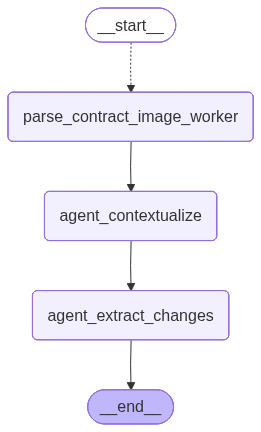

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
#print(graph.get_graph().draw_mermaid())

## Running The Graph on the Dataset

### Test Case 1

In [17]:
input_state = State(dataset[0])
input_state

{'original_path': 'data/test_contracts/01/01_original_scan.pdf',
 'amendment_path': 'data/test_contracts/01/01_amendment_scan.pdf',
 'original_md_path': 'data/test_contracts/01/01_original.md',
 'amendment_md_path': 'data/test_contracts/01/01_amendment.md',
 'changes_readme': 'data/test_contracts/01/README.md'}

In [ ]:
output_state = graph.invoke(
    input_state,
    config={"callbacks": [langfuse_handler]} # Add Langfuse callback handler here
)

In [ ]:
print_highlighted_json(output_state["output"])

{
    "sections_changed": [
        "1.3 Location",
        "2.1 Base Salary",
        "2.2 Performance Bonus",
        "2.3 Equity Compensation",
        "2.5 Paid Time Off",
        "3.3 Severance",
        "5.1 Non-Competition",
        "5.2 Non-Solicitation of Employees"
    ],
    "topics_touched": [
        "Employment Terms",
        "Compensation and Benefits",
        "Work Location and Remote Work",
        "Severance",
        "Non-Competition and Non-Solicitation Covenants"
    ],
    "summary_of_changes": "The amended contract introduces several key changes compared to the original. In Section 1.3 (Location), the amendment adds an option for the Employee to work remotely up to three days per week with manager approval, in addition to the primary San Francisco office location. In Section 2 (Compensation and Benefits), the base salary is increased from $145,000 to $165,000 annually (2.1), the performance bonus potential is raised from 15% to 20% of base salary (2.2), and the

### Test Case 2

In [28]:
input_state = State(dataset[1])
input_state

{'original_path': 'data/test_contracts/02/02_original_scan.pdf',
 'amendment_path': 'data/test_contracts/02/02_amendment_scan.pdf',
 'original_md_path': 'data/test_contracts/02/02_original.md',
 'amendment_md_path': 'data/test_contracts/02/02_amendment.md',
 'changes_readme': 'data/test_contracts/02/README.md'}

In [ ]:
output_state = graph.invoke(
    input_state,
    config={"callbacks": [langfuse_handler]} # Add Langfuse callback handler here
)

In [ ]:
print_highlighted_json(output_state["output"])

{
    "sections_changed": [
        "1. SCOPE OF SERVICES",
        "2. TERM AND TERMINATION",
        "3. COMPENSATION",
        "4. INTELLECTUAL PROPERTY",
        "5. CONFIDENTIALITY",
        "8. INSURANCE",
        "9. GENERAL PROVISIONS",
        "SIGNATURE BLOCKS"
    ],
    "topics_touched": [
        "Scope of Services",
        "Term and Termination",
        "Compensation and Payment Terms",
        "Intellectual Property Rights",
        "Confidentiality",
        "Insurance and Risk Management",
        "General Provisions and Contract Administration"
    ],
    "summary_of_changes": "The amended contract expands the scope of services to include ongoing maintenance and optimization for three months post-deployment, adds new deliverables such as monthly performance optimization reports, and introduces specific performance metrics with service level objectives. The term of the agreement is extended from six to nine months with options for further extensions, and the terminat

## Tests

### Validate Pydantic Output

In [17]:
OutputSchema.model_validate(state["output"])

OutputSchema(sections_changed=['1.3 Location', '2.1 Base Salary', '2.2 Performance Bonus', '2.3 Equity Compensation', '2.5 Paid Time Off'], topics_touched=['Work Location and Flexibility', 'Compensation', 'Bonuses', 'Equity Incentives', 'Paid Time Off'], summary_of_changes="The amended contract introduces several significant changes compared to the original. In Section 1.3 Location, the amendment adds the option for the employee to work remotely up to three days per week, subject to manager approval, enhancing work flexibility. In Section 2.1 Base Salary, the annual salary is increased from $145,000 to $165,000, reflecting a substantial raise. Section 2.2 Performance Bonus increases the maximum bonus potential from 15% to 20% of the base salary, improving incentive compensation. Section 2.3 Equity Compensation raises the stock options granted from 5,000 shares to 8,000 shares, while maintaining the same vesting schedule and plan terms, thereby increasing the employee's equity stake. Fi

### Image Extraction Quality

### Building a Test Graph

In [17]:
from langchain_openai import OpenAIEmbeddings

In [18]:
class TestState(State):
    original_text_extraction_accuracy: float
    amendment_text_extraction_accuracy: float
    embeddings: list[list[float]]

In [19]:
def run_extractor_subgraph(state: State):
    """Run the contract change extractor subgraph"""
    extractor_output_state = graph.invoke(state)
    return extractor_output_state

def get_embeddings(state: TestState):
    """Generate embeddings for extracted markdowns and dataset markdowns"""
    embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)

    vectors = embeddings.embed_documents(
        [
            state["original_markdown_parse"],  # Parsed markdown from the scanned original contract pdf image
            open(state["original_md_path"], "r").read(), # Original markdown from the dataset
            state["amendment_markdown_parse"],  # Parsed markdown from the scanned amendment pdf image
            open(state["amendment_md_path"], "r").read(), # Amendment markdown from the dataset
        ]
    )
    return {"embeddings": vectors}

def calculate_text_extraction_accuracy(state: TestState):
    """Calculate text extraction accuracy using cosine similarity of embeddings"""
    def cosine_similarity(vec1, vec2):
        dot = np.dot(vec1, vec2)
        return dot / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    parsed_original_vec, dataset_original_vec, parsed_amendment_vec, dataset_amendment_vec = state["embeddings"]

    original_similarity = cosine_similarity(parsed_original_vec, dataset_original_vec)
    amendment_similarity = cosine_similarity(parsed_amendment_vec, dataset_amendment_vec)

    return {
        "original_text_extraction_accuracy": float(original_similarity),
        "amendment_text_extraction_accuracy": float(amendment_similarity),
    }

In [20]:
test_graph_builder = StateGraph(TestState)
#test_graph_builder.add_node("extractor_subgraph", graph)
test_graph_builder.add_node(run_extractor_subgraph)
test_graph_builder.add_node(get_embeddings)
test_graph_builder.add_node(calculate_text_extraction_accuracy)
test_graph_builder.add_edge(START, "run_extractor_subgraph")
test_graph_builder.add_edge("run_extractor_subgraph", "get_embeddings")
test_graph_builder.add_edge("get_embeddings", "calculate_text_extraction_accuracy")
test_graph = test_graph_builder.compile()

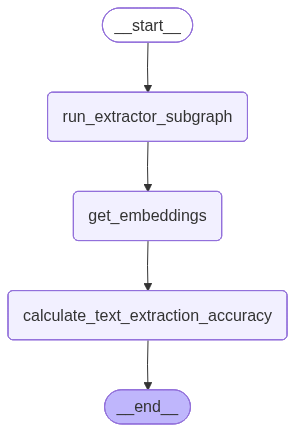

In [21]:
display(Image(test_graph.get_graph().draw_mermaid_png()))

In [ ]:
#print(test_graph.get_graph().draw_mermaid())

### Test Case 1 Extraction Accuracy

In [23]:
input_test_state = TestState(dataset[0])

In [24]:
output_test_state = test_graph.invoke(
    input_test_state,
    config={"callbacks": [langfuse_handler]} # Add Langfuse callback handler here
)

In [26]:
print("Original Contract Text Extraction Accuracy:", output_test_state["original_text_extraction_accuracy"])
print("Amendment Contract Text Extraction Accuracy:", output_test_state["amendment_text_extraction_accuracy"])

Original Contract Text Extraction Accuracy: 0.9779862995364322
Amendment Contract Text Extraction Accuracy: 0.9796767398882005


### Test Case 2 Extraction Accuracy

In [31]:
input_test_state = TestState(dataset[1])

In [32]:
output_test_state = test_graph.invoke(
    input_test_state,
    config={"callbacks": [langfuse_handler]} # Add Langfuse callback handler here
)

In [33]:
print("Original Contract Text Extraction Accuracy:", output_test_state["original_text_extraction_accuracy"])
print("Amendment Contract Text Extraction Accuracy:", output_test_state["amendment_text_extraction_accuracy"])

Original Contract Text Extraction Accuracy: 0.97395442810011
Amendment Contract Text Extraction Accuracy: 0.9701095222088243
